# Part 3. Time series classification - exercise

> Try your best in one of the UCR datasets!

Today you'll apply the knowledge acquired in part 3 to classify one of the datasets
from the popular UCR archive for time series classification (TSC). You don't have
to build the TSC algorithm from scratch if you don't want to, but rather make use
of high level tools, such as:
- [aeon](https://github.com/aeon-toolkit/aeon): Implements every kind of TSC algorithm
covered in this course (distance-based, dictionary-based, deep learning based,
rocket-based...). It is compatible with scikit learn.
- [tsai](https://github.com/timeseriesAI/tsai): Implements many deep neural architectures
for TSC, beyond InceptionTime (e.g. Transformers for time series). It also has a
fast implementation of ROCKET-based algorithms. It is built on top of fastai (which
in turn is built on top of Pytorch)
- [tslearn](https://github.com/tslearn-team/tslearn#available-features): Compatible
with scikit-learn.
- [sk-time](https://github.com/sktime/sktime). Impklements multiple TSC algorithms,
including all of the ones seen in this course

The data we will use in this session comes from The City of Melbourne, Australia. They have developed an
automated pedestrian counting system to better understand pedestrian activity
within the municipality, such as how people use different city locations at
different time of the day. Their objective is to analyse this data in order to
facilitate decision making and urban planning for the future. To see an interactive
webapp with the pedestrianconting system in action, check it out [here](https://www.pedestrian.melbourne.vic.gov.au/#date=11-06-2018&time=4).

To create a TSC dataset out of this experiment, time series researchers have
extracted data of 10 locations for the whole year 2017. The series represent
pedestrian count for 12 months of the year 2017. Classes correspond location of sensor placement:
- Class 1: Bourke Street Mall (North)
- Class 2: Southern Cross Station
- Class 3: New Quay
- Class 4: Flinders St Station Underpass
- Class 5: QV Market-Elizabeth (West)
- Class 6: Convention/Exhibition Centre
- Class 7: Chinatown-Swanston St (North)
- Class 8: Webb Bridge
- Class 9: Tin Alley-Swanston St (West)
- Class 10: Southbank

There is nothing to infer from the order of examples in the train and test set.

## Download the data

In [1]:
from tsai.all import *
import torch
from fastai.data.external import untar_data


path = untar_data('https://timeseriesclassification.com/aeon-toolkit/MelbournePedestrian.zip')
print(path)

/home/ignacio/.fastai/data/MelbournePedestrian


In [2]:
path.ls()

(#13) [Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_TRAIN.ts'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_nmv_TEST.arff'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_nmv_TEST.ts'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_nmv_TRAIN.ts'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian.txt'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_TRAIN.arff'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_TRAIN.txt'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_TEST.txt'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_TEST.arff'),Path('/home/ignacio/.fastai/data/MelbournePedestrian/MelbournePedestrian_TEST.csv')...]

The files `MelbournePedestrian_TRAIN.txt` and `MelbournePedestrian_TEST.txt` contain
the hourly-based pedestrian counts for each of the locations, 1 row per day (24 hours).
```
1.0000000e+00   9.7000000e+01   4.2000000e+01   2.0000000e+01   1.0000000e+01   1.4000000e+01   3.3000000e+01   1.1300000e+02   4.2200000e+02   8.7500000e+02   1.0030000e+03   1.3510000e+03   1.6130000e+03   2.9370000e+03   2.9540000e+03   2.1670000e+03   2.3300000e+03   2.1910000e+03   2.6210000e+03   2.4000000e+03   1.8920000e+03   1.2530000e+03   8.4400000e+02   4.3800000e+02   2.0400000e+02
```
In the example above, the first number represents the class (1 in this case), and
the rest 24 numbers are the pedestrian count at every hour of the day.

From now on, you'll be in charge of loading the data, preprocessing and visualising it,
splitting the training set into train/valid sets if needed, and of course, run whatever TSC
algorithm you choose and compare them.

You can also add covariates to the dataset, i.e., auxiliary variables that make the
data multivariate and can help the model understand better the patterns
(e.g., hour of the day, rolling mean, ...)

To evaluate the results on the test set, you can use any classic classification
metric, such as the accuracy, the F1 (multiclass), precision, or recall. Also,
have a look at the confusion matrix, and plot the samples that are misclassified
with a higher error, to see if you find patterns in they way the model fails.

## Data

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

file = os.path.join(path, 'MelbournePedestrian_TRAIN.txt')
train = pd.read_csv(file, sep='  ', header=None)
## change column 0 to int
train[0] = train[0].astype(int)
train_data = train.copy()

train_split, val_split = train_test_split(train, test_size=0.15, stratify=train[0])
split = ( train_split.index.values, val_split.index.values,)

file = os.path.join(path, 'MelbournePedestrian_TEST.txt')
test_data = pd.read_csv(file, sep='  ', header=None)
## change column 0 to int
test_data[0] = test_data[0].astype(int)

## column 0 -1
train_data[0] = train_data[0] - 1
test_data[0] = test_data[0] - 1

In [4]:
print(split)

(array([154, 949, 199, ..., 243, 194, 181]), array([  80,   79,  534,  448,  955,  653,  326, 1092,  235,  800,  852,
        941,  544,  873,  351,  104,  420, 1002,  376,  502,  413,  584,
        697,  409,  248,  185,  798,  360,  824,  830, 1169,  998, 1074,
        483,  103, 1168,  164,  985,  687,  689, 1109,  507,  152,  906,
        880,  134,  840,  476,  491,  139,  744, 1116,   45,  702,  650,
       1007,  793,  896,  577,  136,  740,  270,  787, 1133,  403, 1188,
        912,   36,  609,  251,  207, 1030,  417,  690,  987, 1174,  962,
         81,  701,  988,  973,  815,  287,   32, 1034,  484,  765,   15,
         41,  328,  598,  488,  854,  783,  273, 1172,  223,  718,  642,
        916,  494,  858, 1117,  524, 1163,  935,  540,  316,  471, 1115,
        647,  672,  691,  910,  260, 1140,  754,  595,  721, 1086,  501,
        741,   92,   63,  258, 1059,  380,   49,  663,  971, 1037,  890,
        242,  574,  763,   26,  913, 1084,  144,  680,  957,  314,  214,
      

In [5]:
import seaborn as sns

X_train, y_train = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
X_test, y_test = test_data.iloc[:, 1:].values, test_data.iloc[:, 0].values

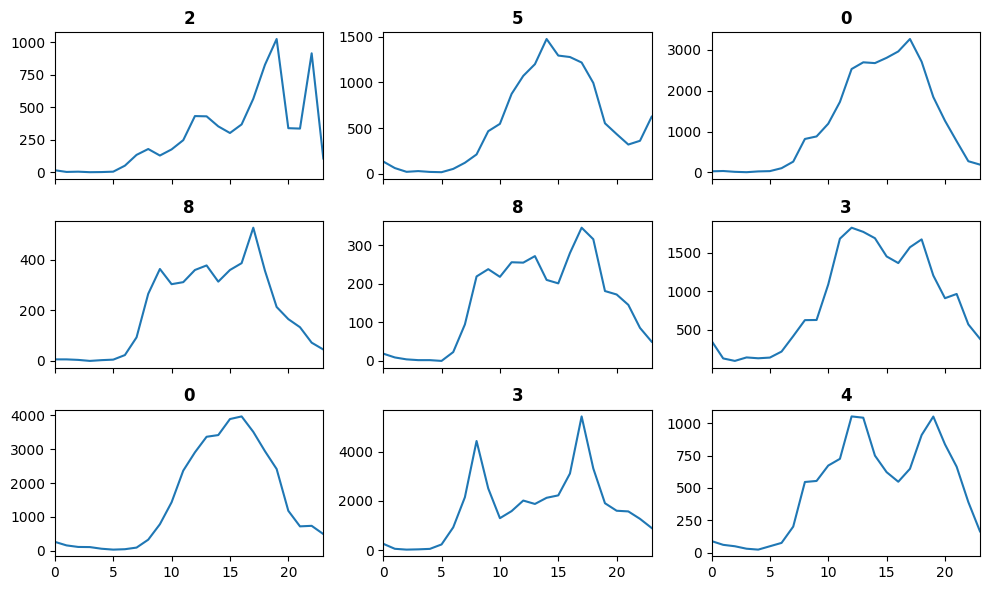

In [6]:



## create dataloaders
bs = 64
tfms = [None, TSClassification()]
#batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X_train, y_train, splits=split, bs=bs, tfms=tfms)#, batch_tfms=batch_tfms
dls.show_batch(figsize=(10, 6))

In [7]:
InceptionTimePlus?


Init signature:
InceptionTimePlus(
    c_in,
    c_out,
    seq_len=None,
    nf=32,
    nb_filters=None,
    flatten=False,
    concat_pool=False,
    fc_dropout=0.0,
    bn=False,
    y_range=None,
    custom_head=None,
    *,
    ks=40,
    bottleneck=True,
    padding='same',
    coord=False,
    separable=False,
    dilation=1,
    stride=1,
    conv_dropout=0.0,
    sa=False,
    se=None,
    norm='Batch',
    zero_norm=False,
    bn_1st=True,
    act=<class 'torch.nn.modules.activation.ReLU'>,
    act_kwargs={},
)
Docstring:     
A sequential container.

Modules will be added to it in the order they are passed in the
constructor. Alternatively, an ``OrderedDict`` of modules can be
passed in. The ``forward()`` method of ``Sequential`` accepts any
input and forwards it to the first module it contains. It then
"chains" outputs to inputs sequentially for each subsequent module,
finally returning the output of the last module.

The value a ``Sequential`` provides over manually callin

In [8]:
## model and training

model = build_ts_model(XceptionTimePlus, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
learn = ts_learner(dls, metrics=accuracy)

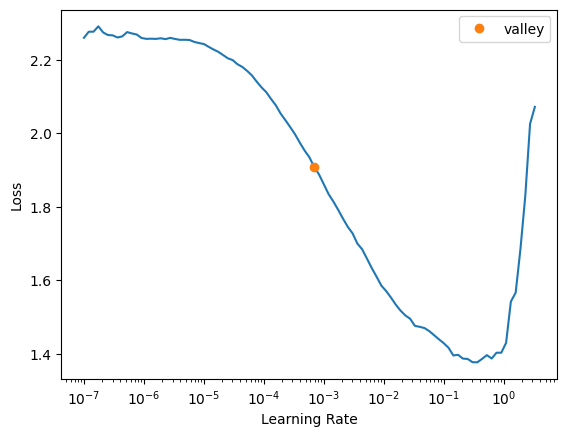

In [9]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.040048,2.254431,0.100000,00:00
1,1.815991,1.988261,0.416667,00:00
2,1.642541,1.522096,0.605556,00:00
3,1.480794,1.218648,0.605556,00:00
4,1.324582,1.028318,0.711111,00:00
5,1.182779,0.837220,0.794444,00:00
6,1.042899,0.661596,0.850000,00:00
7,0.911261,0.559234,0.827778,00:00
8,0.797469,0.501003,0.855556,00:00
9,0.710362,0.690970,0.794444,00:00


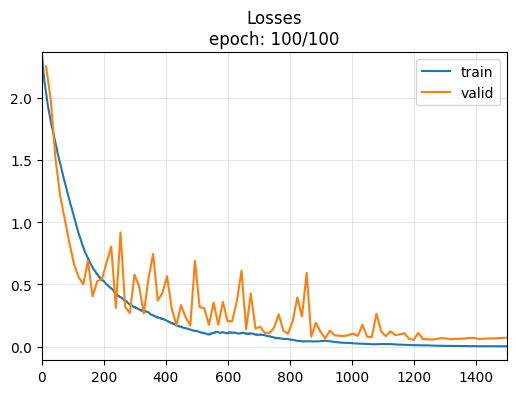

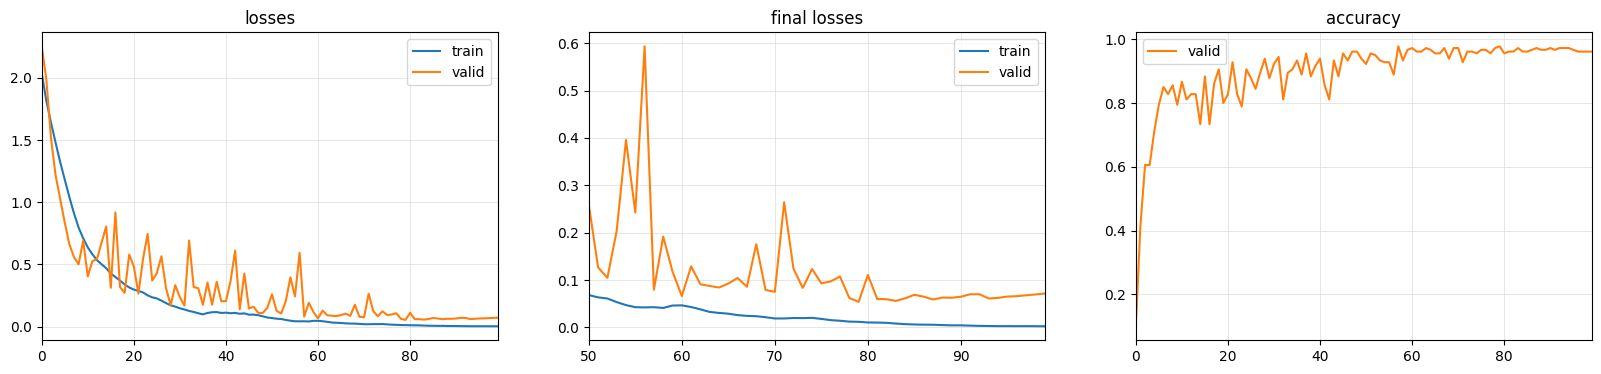

In [10]:
learn = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(100, lr_max=lr)

In [11]:
## test with the test set
bs = 64
tfms = [None, TSClassification()]
#batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X_test, y_test, bs=bs, tfms=tfms)#, batch_tfms=batch_tfms

count = 0
preds = learn.get_preds(dl=dls[0])
for p, t in zip(preds[0], y_test):
    if torch.argmax(p, dim=0).item() == t:
        count += 1

print(f'accuracy: {count/len(y_test)}')

accuracy: 0.966789667896679
